In [1]:
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.layers import Input, Dense

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)


from minigraphnets import Node , Edge, Graph

In [2]:
%load_ext autoreload
%autoreload 2
from random_field_model import *

In [27]:
## Creation of the random field data:
# Creates a 20x20 grid of points and a random field with them.
k = ExpQuadKernel(0.3)
#points = np.random.randn(10,2)
npoints = 20
[xx,yy] = np.meshgrid(np.linspace(-1,1,npoints), np.linspace(-31,1,npoints))
points = np.vstack([xx.flatten(), yy.flatten()]).T
C = k.get_chol(points)

r = np.random.randn(np.prod(xx.flatten().shape))
all_vals = [];
for i in range(2):
    vals = r @ C.T
    r = np.random.randn(np.prod(xx.flatten().shape))
    all_vals.append(vals) #vals.reshape(xx.shape))

# samples a single graph from 1 of the sampled random fields:
in_graph , out_graph = sample_graph_from_2d_result(points, all_vals[0])
input_graphs, output_graphs  = get_multiple_graph_samples_random_fields(5,all_vals,points)
#[len(e.edges) for e in input_graphs]


.
.


In [28]:
%load_ext autoreload
%autoreload 2
from graphnet_utils import * 
from random_field_model import * 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
#graph_state_size = (10,);
graph_state_size = 10;
qoi_size = 1; # dimension of the random field.
functions_encode = make_mlp_graphnet_functions(15,input_size=1, output_size=graph_state_size, graph_indep=True)
functions_core   = make_mlp_graphnet_functions(15,input_size = graph_state_size,output_size = graph_state_size)
functions_decode = make_mlp_graphnet_functions(15,input_size = graph_state_size,output_size=1, graph_indep = True)

gn_encode = GraphNet(**functions_encode)
gn_process = GraphNet(**functions_core)
gn_decode = GraphNet(**functions_decode)

def eval_network(graph, core_iterations = 3, residual = True, eval_mode = "batched"):
    g = gn_encode.graph_eval(graph.copy(), eval_mode = eval_mode)
    for k in range(core_iterations):
        if residual:
            g = g + gn_process.graph_eval(g, eval_mode= eval_mode)
        else:
            g = gn_process.graph_eval(g, eval_mode = eval_mode)
            
    return gn_decode.graph_eval(g, eval_mode = eval_mode)

res = eval_network(input_graphs[0])

In [ ]:
res            
            
            
    


In [81]:
input_graphs[2].edges[0].edge_tensor

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [49]:
input_graphs[0].edges[2].edge_tensor.shape

TensorShape([1, 32])

In [49]:
s= output_graphs[0].nodes[0].get_state()
len(s.shape)

0

In [19]:
help(GraphNet)

Help on class GraphNet in module graphnet_utils:

class GraphNet(builtins.object)
 |  Input is a graph and output is a graph.
 |  Encapsulates a GraphNet computation iteration.
 |  
 |  Supports model loading and saving (for a single GraphNet)
 |  
 |  Should treat the situations where edge functions do not exist more uniformly.
 |  Also there is no Special treatment for "globals".
 |  
 |  Methods defined here:
 |  
 |  __init__(self, edge_function=None, node_function=None, edge_aggregation_function=None, node_to_prob=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  eval_edge_functions(self, graph, eval_mode='batched')
 |      Evaluate all edge functions. Batched mode has some shape juggling going on.
 |      If you see weird behaviour that's the first place to look (tests not written yet. :totest:)
 |      
 |      params:
 |        graph     - the graph containing the edges 
 |        eval_mode - "safe" or "batched" (batched is also safe if state

In [5]:
class ExpQuadKernel:
    def __init__(self,l):
        """
        An exponentiated quadradic kernel function.
        """
        self.l = l
    
    def kernel_function(self, t,s):
        return np.exp(-(np.linalg.norm(t-s)**2)/self.l**2)
    
    def get_kernel(self, points):
        K = np.zeros([points.shape[0], points.shape[0]])
        for i,p in enumerate(points):
            for j,q in enumerate(points):
                if i>=j:
                    K[i,j] = self.kernel_function(p,q)
                
        K = K + K.T-np.diag(np.diag(K))+np.eye(K.shape[0])*0.001
        #K = K + np.eye(K.shape[0])*np.min(K)*1e-20
        return K
    
    def get_chol(self, points):
        K = self.get_kernel(points)
        return np.linalg.cholesky(K)
    
k = ExpQuadKernel(0.5) 
#points = np.random.randn(10,2)
npoints = 20
[xx,yy] = np.meshgrid(np.linspace(-1,1,npoints), np.linspace(-1,1,npoints))
points = np.vstack([xx.flatten(), yy.flatten()]).T
C = k.get_chol(points)

                    
                
        
        
    

In [6]:

r = np.random.randn(np.prod(xx.flatten().shape))
all_vals = [];
for i in range(100):
    vals = r @ C.T
    r = np.random.randn(np.prod(xx.flatten().shape))
    all_vals.append(vals) #vals.reshape(xx.shape))
    #pplot.pause(0.01)
    


In [7]:
from minigraphnets import Graph, Node, Edge

In [8]:
all_vals[0].shape

(400,)

In [9]:
#pplot.pcolor(all_vals[2])
def sample_graph_from_2d_result(points, all_vals_, pct_x = 10, pct_y = 10, cutoff = 0.5):
    u = np.random.uniform(all_vals_) # split data randomly and exclusively in two sets (source and target datapoints)
    my = (u <= (pct_x/100 + pct_y/100)) * (u>pct_x/100)
    mx = (u <= (pct_x/100 + pct_y/100)  * (u<=pct_x/100))
    
    points_x , points_y= [points[m_] for m_ in [mx,my]]
    vals_x, vals_y = [all_vals_[m_] for m_ in [mx, my]]
    # make a graph out of this:
    # Input graph has zero at the vals_y and edges with source nodes the "points_x" and destination "points_y".
    input_node_features = np.hstack([vals_x, np.zeros_like(vals_y)])
    
    all_points = np.vstack([points_x, points_y])
    all_nodes = []
    all_edges = []
    unobserved_nodes = [];
    observed_nodes = [];
    
    all_nodes_output = []
    for p1, source_node_val in zip(points_x, vals_x):
        source_node = Node(source_node_val)
        # Make bi-directional edges for the points that are observed:
        for p2, dest_node_val in zip(points_x, vals_x):
            if np.linalg.norm(p2 - p1) < cutoff:
                dest_node = Node(dest_node_val)
                
                all_nodes.append(dest_node)
                all_nodes_output.append(dest_node)
                
                observed_nodes.append(dest_node)
                
                d = np.abs(p1 - p2)
                all_edges.append(Edge(node_from=source_node, node_to=dest_node , edge_attr_tensor=d ))
                all_edges.append(Edge(node_from = dest_node, node_to = source_node, edge_attr_tensor = d))
            
        # make uni-directional edges for the unobserved points
        for p2, dest_node_val in zip(points_y, vals_y):
            if np.linalg.norm(p2 - p1) < cutoff:
                dest_node_input = Node(dest_node_val * 0)
                dest_node_output = Node(dest_node_val)
                
                all_nodes.append(dest_node_input)
                all_nodes_output.append(dest_node_output)
                d = np.abs(p1 - p2)
                all_edges.append(Edge(node_from=source_node, node_to=dest_node , edge_attr_tensor=d ))

            
    input_graph = Graph( all_nodes, all_edges)
    output_graph = Graph( all_nodes_output, [])
    return input_graph, output_graph

in_graph , out_graph = sample_graph_from_2d_result(points, all_vals[0])

    #nodes = [Node()]
    #output_values = vals_y # each value corresponds to one node.
    
    
    

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5255629001100921,
 0.783885040863878,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5255629001100921,
 0.783885040863878,
 0.8570329206704572,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5255629001100921,
 0.783885040863878,
 0.8570329206704572,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

In [14]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Dropout
#from graphnet_utils import GraphNet
def make_mlp(input_shape = (1,), output_shape = (1,), size = 100 ):
    x = Input(input_shape)
    y = Dense(size, "relu")(x)
    y = Dropout(rate = 0.2)(y)
    y = Dense(units = size, activation = "relu")(y)
    y = Dense(units = output_shape[0])(y)
    
    return tf.keras.Model(inputs = x , outputs=  y)

m = make_mlp()

            
    

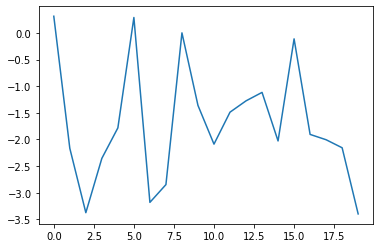

In [240]:
pplot.plot(vals.reshape(xx.shape)[:,10])

In [162]:
# Create graph data from GP results:

# 1) The source (observation) nodes are, say, 10% of the input
# 2) the edge features is the distance between points
# 3) the destination nodes are another 5% of the nodes
import graph_nets as gn

In [98]:
import fbm
f = fbm.FBM(n=1024, hurst=0.30, length=10, method='daviesharte')

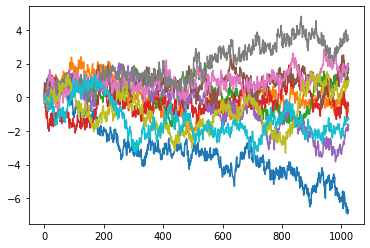

In [99]:
for k in range(10):
    s = f.fbm()
    #pplot.scatter(range(0,len(s)),s, alpha = 0.5)
    pplot.plot(s)


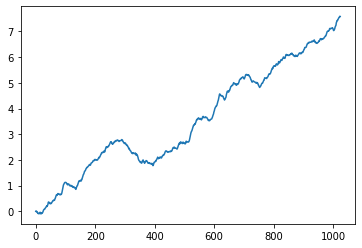

In [62]:
import matplotlib.pyplot as pplot


In [2]:
from graphnet_utils import GraphNet, GraphNetFunctionFactory

In [3]:
gn = GraphNetFunctionFactory()

In [5]:
gn.make_graphnet_comp_blocks(100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [8]:

GraphNetFunctionFactory.make_edge_aggregation_function(self = None,edge_out_shape  = 10)

In [20]:
class aaa:
    def __init__(self):
        self.make_asdf(3)
        
    @classmethod
    def make_asdf(self,k):
        return "asdf" + str(k)
    

aaa()

In [21]:
aaa.make_asdf(3)

'asdf3'